In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from robo_limb_ml.models.fk_lstm import FK_LSTM
from robo_limb_ml.models.fk_mlp import FK_MLP
from robo_limb_ml.models.fk_rnn import FK_RNN
from robo_limb_ml.models.fk_seq2seq import FK_SEQ2SEQ


In [2]:
input_size = 6
hidden_size = 512
num_layers = 3
batch_size = 512
output_size = 4
seq_len = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_path = "/home/ubuntu/Research-HW/SML/RobLimbFK/robo_limb_ml/model_weights/new_weights/LSTM_b512_e200_s-1_LSTM_len10_1722940896"
model_path = "../../model_weights/new_weights/LSTM_b512_e200_s-1_LSTM_len50_1722938560"
model = FK_LSTM(input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_size=batch_size,
                output_size=output_size,
                device=device,
                batch_first=True).to(device=device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.h0 = torch.zeros(num_layers, 1, hidden_size).to(device=device)
model.c0 = torch.zeros(num_layers, 1, hidden_size).to(device=device)

device of LSTM cpu


In [3]:
test_df = pd.read_csv("../../ml_data/test_data.csv").dropna()



In [4]:
# test_df = test_df[['time_begin', 'time_begin_traj', 'theta_x', 'theta_y',
#        'X_throttle', 'Y_throttle' , 'vel_x', 'vel_y']]
test_df = test_df.reindex(columns=['time_begin', 'time_begin_traj', 'theta_x', 'theta_y',
       'X_throttle', 'Y_throttle' , 'vel_x', 'vel_y'], copy=False)

: 

In [5]:
from tqdm import tqdm
test_tensor = torch.tensor(test_df.values.copy(), dtype=torch.float32).to(device=device)
# obs_tensor = torch.tensor(test_df.drop(columns=["vel_x", "vel_y"]).values, dtype=torch.float32).to(device=device)
outputs = torch.zeros(test_df.shape).to(device=device)
outputs[:seq_len] = test_tensor[:seq_len].clone()
hn = torch.zeros(3, 1, 512).to(device=device)
cn = torch.zeros(3, 1, 512).to(device=device)
for i in tqdm(range(seq_len, test_df.shape[0])):
    data = outputs[i - seq_len:i, :-2]
    time_begin, time_begin_traj, theta_x, theta_y, X_throttle, Y_throttle, vel_x, vel_y  = test_tensor[i - 1]
    delta_states, hn, cn = model(data.unsqueeze(0), hn, cn)
    delta_states = delta_states.squeeze()
    time_begin_1, time_begin_traj_1, _, _, X_throttle_1, Y_throttle_1, _, _ = test_tensor[i]
    pred_theta_x, pred_theta_y, pred_vel_x, pred_vel_y = delta_states[0] + theta_x, delta_states[1] + theta_y, delta_states[2] + vel_x, delta_states[3] + vel_y
    outputs[i] = torch.tensor([time_begin_1, time_begin_traj_1, pred_theta_x, pred_theta_y, X_throttle_1, Y_throttle_1, pred_vel_x, pred_vel_y]).to(device=device)

 13%|█▎        | 3951/31216 [01:58<06:55, 65.56it/s]   

In [ ]:
outputs_df = pd.DataFrame(outputs.cpu().detach().numpy(), columns=test_df.columns)
output_states = torch.tensor(outputs_df[['theta_x', 'theta_y', 'vel_x', 'vel_y']].values, dtype=torch.float32).to(device=device)
test_states = torch.tensor(test_df[['theta_x', 'theta_y', 'vel_x', 'vel_y']].values, dtype=torch.float32).to(device=device)
from torcheval.metrics import R2Score
metric = R2Score()
metric.update(test_states, output_states)
r2_score = metric.compute()
print("R^2", r2_score.item())

rmse = torch.sqrt(nn.MSELoss()(test_states, output_states))
print("RMSE", rmse.item())

R^2 0.8196448087692261
RMSE 10.591256141662598


In [ ]:
outputs_df = pd.DataFrame(outputs.cpu().detach().numpy(), columns=test_df.columns)

C:\Users\ansue\AppData\Local\Temp\ipykernel_3452\1422044966.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


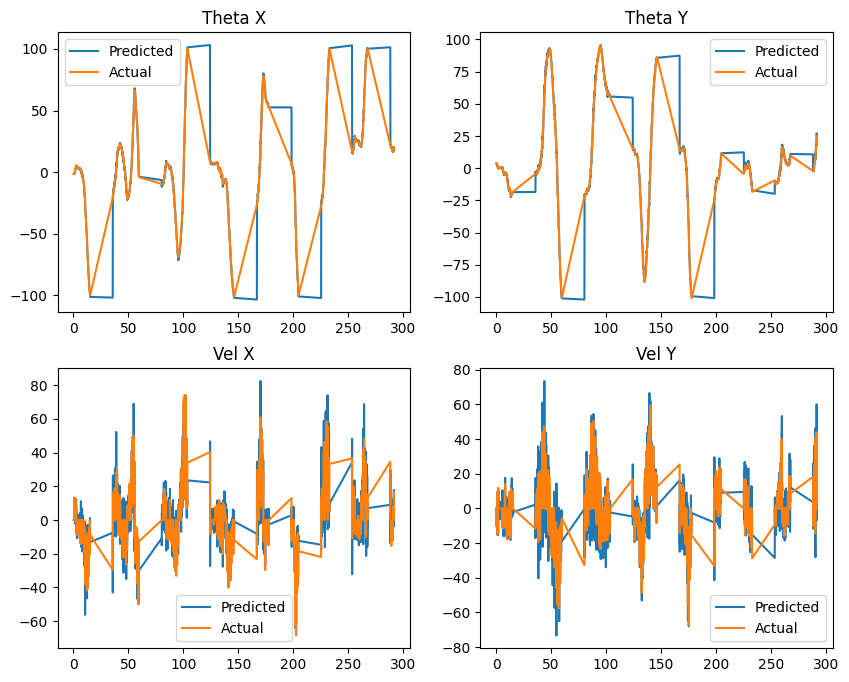

In [ ]:
display_window = 1500
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(outputs_df["time_begin"][:display_window], outputs_df["theta_x"][:display_window], label="Predicted")
axs[0, 0].plot(test_df["time_begin"][:display_window], test_df["theta_x"][:display_window], label="Actual")
axs[0, 0].set_title("Theta X")
axs[0, 0].legend()
axs[0, 1].plot(outputs_df["time_begin"][:display_window], outputs_df["theta_y"][:display_window], label="Predicted")
axs[0, 1].plot(test_df["time_begin"][:display_window], test_df["theta_y"][:display_window], label="Actual")
axs[0, 1].set_title("Theta Y")
axs[0, 1].legend()
axs[1, 0].plot(outputs_df["time_begin"][:display_window], outputs_df["vel_x"][:display_window], label="Predicted")
axs[1, 0].plot(test_df["time_begin"][:display_window], test_df["vel_x"][:display_window], label="Actual")
axs[1, 0].set_title("Vel X")
axs[1, 0].legend()
axs[1, 1].plot(outputs_df["time_begin"][:display_window], outputs_df["vel_y"][:display_window], label="Predicted")
axs[1, 1].plot(test_df["time_begin"][:display_window], test_df["vel_y"][:display_window], label="Actual")
axs[1, 1].legend()
axs[1, 1].set_title("Vel Y")
fig.show()